In [1]:
import pandas as pd
from scipy.stats import chi2_contingency, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import numpy as np

df = pd.read_csv("cleaned_airbnb_Chicago.csv")


Find important features

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


#### build the xgboost model

# List of numerical and categorical columns
numerical_cols = ['available_days', 'booked_days', 'Bedrooms', 'Bathrooms', 'Max Guests',
                  'Cleaning Fee (USD)', 'Minimum Stay', 'Number of Photos',
                  'Number of Reviews', 'Rating Overall', 'occupancy_rate', 'Instantbook Enabled']
categorical_cols = ['Property Type', 'Listing Type', 'Pets Allowed']

# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Preprocess the entire dataset first
X = df.drop('Nightly Rate', axis=1)
X_preprocessed = preprocessor.fit_transform(X)

# Separate target variable
y = df['Nightly Rate']

# Split the preprocessed data into training and testing sets
X_train_preprocessed, X_test_preprocessed, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Define and fit the initial model on the preprocessed data
initial_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
initial_model.fit(X_train_preprocessed, y_train)


#### find the important features
# Set a threshold for important features
importance_threshold = 0.005

# Get feature importances and feature names after preprocessing
feature_importances = initial_model.feature_importances_
all_features = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))

# Select important features based on your threshold or criteria
important_features_indices = [idx for idx, importance in enumerate(feature_importances) if importance > importance_threshold]
important_features = [all_features[idx] for idx in important_features_indices]


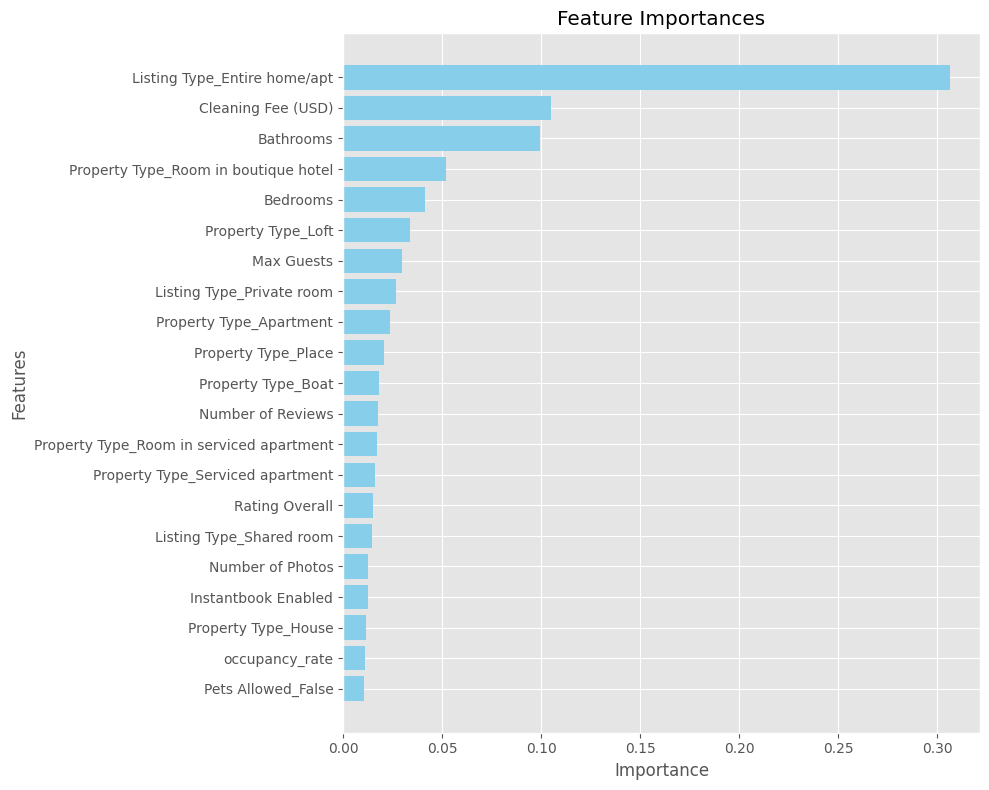

In [7]:
# Set a threshold for important features
importance_threshold = 0.009

# Get feature importances and feature names after preprocessing
feature_importances = initial_model.feature_importances_
all_features = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))

# Dictionary to store feature importances
feature_importance_dict = {}

# Loop over all features and their importances
for idx, feature_name in enumerate(all_features):
    importance = feature_importances[idx]
    feature_importance_dict[feature_name] = importance

# Filter out features below the importance threshold
feature_importance_dict = {feature: importance for feature, importance in feature_importance_dict.items() if importance > importance_threshold}

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Split the feature names and their importance scores
sorted_feature_names, sorted_importances = zip(*sorted_features)


# Plotting feature importances
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.style.use('ggplot')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis so the most important feature is on top
plt.tight_layout()
plt.show()

# # Optionally, save the sorted feature importances to a file
# sorted_feature_importances_df = pd.DataFrame(list(sorted_features), columns=['Feature', 'Importance'])
# sorted_feature_importances_df.to_csv('sorted_feature_importances.csv', index=False)


In [10]:
# New model


# Filter the preprocessed dataset to include only important features
X_train_important = X_train_preprocessed[:, important_features_indices]
X_test_important = X_test_preprocessed[:, important_features_indices]

# Train a new model on the important features
new_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
new_model.fit(X_train_important, y_train)

# Evaluate the new model
y_pred = new_model.predict(X_test_important)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}, R-squared: {r2}')

RMSE: 89.51114758767845, R-squared: 0.6385830586039459


In [13]:
# Assuming sample_index is the index of the sample we want to use
sample_index = 0  # You can change this to any valid index

# Retrieve the original data for the sample
original_sample_data = X_test_important.iloc[sample_index]

feature_names = []
feature_values = []

# Print each feature name and its corresponding value for the sample input
print("Input Features and their values for the sample:")
for feature in numerical_cols:
    print(f"{feature}: {original_sample_data[feature]}")
    feature_names.append(feature)
    feature_values.append(original_sample_data[feature])



for feature in categorical_cols:
    # For categorical features, we need to show the original string value
    print(f"{feature}: {original_sample_data[feature]}")
    feature_names.append(feature)
    feature_values.append(original_sample_data[feature])

# Reshape the preprocessed sample input to be two-dimensional
sample_input_important = X_test_important[sample_index].reshape(1, -1)

# Make a prediction with the new model using the important features
sample_prediction = new_model.predict(sample_input_important)

# Print the prediction
print(f"\nThe predicted nightly rate for the sample input is: {sample_prediction[0]:.2f}")


AttributeError: 'csr_matrix' object has no attribute 'iloc'